In [1]:
import os
import numpy as np
import torch
import soundfile as sf
from datasets import load_dataset
from typing import Dict, List, Union
from transformers import BertTokenizerFast, Wav2Vec2FeatureExtractor, Wav2Vec2Model

In [2]:
class LibriPreprocessor:
  def __init__(self):
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
    self.extractor = Wav2Vec2FeatureExtractor.from_pretrained('facebook/wav2vec2-base')
    self.feature_encoder = Wav2Vec2Model.from_pretrained('facebook/wav2vec2-base').feature_extractor
    self.feature_encoder.to(self.device)
    self.feature_encoder.eval()
  
  
  def speech_file_to_array_fn(self, data):
    #import soundfile as sf
    #speech_array, sampling_rate = sf.read(data["file"])
    data['speech'] = data['audio']['array']
    data['sampling_rate'] = data['audio']['sampling_rate']
    #data["target_text"] = data["text"]
    return data
    
    
  def prepare_dataset(self, data): 
    # check that all files have the correct sampling rate
    assert (
        len(set(data['sampling_rate'])) == 1
    ), f"Make sure all inputs have the same sampling rate of {self.extractor.sampling_rate}."

    # extract and pad input values
    input_values = self.extractor(data['speech'], sampling_rate=data['sampling_rate'][0])
    data['input_values'] = input_values.input_values
    padded_input_values = self.extractor.pad(input_values, return_tensors='pt')
    
    # compute the latent features from the conv module
    import torch
    with torch.no_grad():
      input_values = padded_input_values['input_values'].to(self.device)
      latent_features = self.feature_encoder(input_values).transpose(1, 2)
      latent_features = latent_features.cpu().numpy()
      data['latent_features'] = latent_features
    
    # tokenize text
    tokenized_batch = self.tokenizer(data['text'], padding='longest', max_length=128, pad_to_max_length=False)
    data['input_ids'] = tokenized_batch['input_ids']
    data['attention_mask_text'] = tokenized_batch['attention_mask']
    data['token_type_ids_text'] = tokenized_batch['token_type_ids']
    
    return data
  
  
  def pad_latent_features(self, latent_features, padding='longest', return_tensors="pt"):
    padding_value = 0.0
    if padding == 'longest':
      longest_latent_feature = max(len(item['latent_features']) for item in latent_features)

    padded_features = []
    for item in latent_features:
      latent_features_as_ndarray = np.array(item['latent_features']).astype(np.float32)
      padded_item = np.pad(latent_features_as_ndarray, 
                           ((0, longest_latent_feature - latent_features_as_ndarray.shape[0]), (0, 0)), 
                           mode='constant', 
                           constant_values=padding_value)
      if return_tensors == "pt":
        padded_item = torch.from_numpy(padded_item).to(torch.float32)
      padded_features.append(padded_item)
      
    if return_tensors == "pt":
      padded_features = torch.stack(padded_features)
      
    return padded_features


  def __call__(
    self,
    batch: List[Dict[str, Union[List[int], torch.Tensor]]],
    ) -> Dict[str, torch.Tensor]:
    """
    Collate function to be used when training with PyTorch Lightning.
    Returns:
        :obj:`Dict[str, torch.Tensor]`: A dictionary of tensors containing the collated features.
    """ 
    latent_features = [{'latent_features': feature['latent_features']} for feature in batch]
    # input_values = [{'input_values': feature['input_values']} for feature in batch]
    input_sentences = [{'input_ids': feature['input_ids']} for feature in batch]
    
    text_batch = self.tokenizer.pad(
        input_sentences,
        padding='longest',
        return_tensors='pt'
    )
    
    speech_batch = self.pad_latent_features(
        latent_features,
        padding='longest',
        return_tensors="pt",
    )
    
    # speech_batch = self.extractor.pad(
    #     input_values,
    #     padding='longest',
    #     return_tensors="pt",
    # )
    
    return speech_batch, text_batch

In [3]:
load_dataset('librispeech_asr', 'clean')

Extracting data files: 100%|██████████| 4/4 [03:49<00:00, 57.40s/it]


Dataset librispeech_asr downloaded and prepared to C:\Users\marco\.cache\huggingface\datasets\librispeech_asr\clean\2.1.0\14c8bffddb861b4b3a4fcdff648a56980dbb808f3fc56f5a3d56b18ee88458eb. Subsequent calls will reuse this data.


100%|██████████| 4/4 [00:07<00:00,  2.00s/it]


DatasetDict({
    train.100: Dataset({
        features: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id'],
        num_rows: 28539
    })
    train.360: Dataset({
        features: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id'],
        num_rows: 104014
    })
    validation: Dataset({
        features: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id'],
        num_rows: 2703
    })
    test: Dataset({
        features: ['file', 'audio', 'text', 'speaker_id', 'chapter_id', 'id'],
        num_rows: 2620
    })
})

In [2]:
libri = load_dataset('librispeech_asr', 'clean', split='train.360')
print(len(libri))

Reusing dataset librispeech_asr (C:\Users\marco\.cache\huggingface\datasets\librispeech_asr\clean\2.1.0\14c8bffddb861b4b3a4fcdff648a56980dbb808f3fc56f5a3d56b18ee88458eb)


104014


In [6]:
test_shard = libri.shard(16, 0)

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

test = tokenizer(test_shard[0]['text'], padding='longest', max_length=64, truncation=True, pad_to_max_length=False)
print(test)
# truncated_shard = test_shard.filter(lambda x: len(x['text']) < 128, num_proc=os.cpu_count())

{'input_ids': [101, 1996, 2117, 1999, 5197, 2003, 2004, 4076, 12601, 2089, 2022, 4225, 2000, 2022, 1996, 2157, 1997, 2437, 4277, 1999, 2605, 1996, 2332, 2428, 11110, 1037, 4664, 1997, 1996, 11074, 2373, 2144, 1996, 4277, 2031, 2053, 3635, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [7]:
len(test['input_ids'])

38

In [10]:
print(len(test_shard[0]['audio']['array'])/16000)

14.12


In [11]:
test_shard[0]['text']

'THE SECOND IN IMPORTANCE IS AS FOLLOWS SOVEREIGNTY MAY BE DEFINED TO BE THE RIGHT OF MAKING LAWS IN FRANCE THE KING REALLY EXERCISES A PORTION OF THE SOVEREIGN POWER SINCE THE LAWS HAVE NO WEIGHT'

In [5]:
print(len(test_shard))
print(len(truncated_shard))

6501
1133


In [ ]:
input_lengths = {
    'input values lenghts': [],
    'input ids lenghts': []
}
for i in range(len(truncated_shard)):
    input_lengths['input values lenghts']

In [4]:
libri = load_dataset('librispeech_asr', 'clean', split='train.360')
preprocessor = LibriPreprocessor()

num_shards = 16

for i in range(num_shards-0):
    if i > 10:
        print(f"Creating shard {i}")
        libri_shard = libri.shard(num_shards, i)
        libri_shard = libri_shard.map(preprocessor.speech_file_to_array_fn, remove_columns=['file', 'audio', 'speaker_id', 'chapter_id', 'id'])
        print(f"Shard {i} has {len(libri_shard)} items before filtering.")
        libri_filtered = libri_shard.filter(lambda x: len(x['speech'])//x['sampling_rate'] < 16, num_proc=os.cpu_count()) # 16 seconds is the max length of audio
        print(f"Shard {i} has {len(libri_filtered)} items after filtering.")
        libri_prepared = libri_filtered.map(preprocessor.prepare_dataset, batch_size=16, num_proc=1, batched=True, remove_columns=['text', 'sampling_rate'])
        # libri_prepared.save_to_disk(f"../data/librispeech/{i}/")
        libri_prepared.save_to_disk(f"E:/Machine Learning/Datasets/librispeech/{i}/")

Reusing dataset librispeech_asr (C:\Users\marco\.cache\huggingface\datasets\librispeech_asr\clean\2.1.0\14c8bffddb861b4b3a4fcdff648a56980dbb808f3fc56f5a3d56b18ee88458eb)
c:\Users\marco\Google Drive\Projects\.venv\speech-segment-retrieval\lib\site-packages\transformers\configuration_utils.py:363: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2Model: ['project_hid.weight', 'quantizer.codevectors', 'quantizer.weight_proj.weight', 'project_hid.bias', 'project_q.weight', 'quantizer.weight_proj.bias', 'project_q.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with ano

Creating shard 5


100%|██████████| 6501/6501 [01:00<00:00, 108.23ex/s]


Shard 5 has 6501 items before filtering.
Shard 5 has 6097 items after filtering.


  0%|          | 0/382 [00:00<?, ?ba/s]c:\Users\marco\Google Drive\Projects\.venv\speech-segment-retrieval\lib\site-packages\transformers\feature_extraction_utils.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
100%|██████████| 382/382 [15:05<00:00,  2.37s/ba]


Creating shard 6


100%|██████████| 6501/6501 [01:01<00:00, 105.73ex/s]


Shard 6 has 6501 items before filtering.
Shard 6 has 6089 items after filtering.


100%|██████████| 381/381 [14:16<00:00,  2.25s/ba]


Creating shard 7


100%|██████████| 6501/6501 [00:59<00:00, 109.42ex/s]


Shard 7 has 6501 items before filtering.
Shard 7 has 6133 items after filtering.


100%|██████████| 384/384 [14:21<00:00,  2.24s/ba]


Creating shard 8


100%|██████████| 6501/6501 [00:59<00:00, 109.17ex/s]


Shard 8 has 6501 items before filtering.
Shard 8 has 6090 items after filtering.


100%|██████████| 381/381 [13:37<00:00,  2.14s/ba]


Creating shard 9


100%|██████████| 6501/6501 [01:01<00:00, 105.84ex/s]


Shard 9 has 6501 items before filtering.
Shard 9 has 6113 items after filtering.


100%|██████████| 383/383 [14:12<00:00,  2.23s/ba]


Creating shard 10


100%|██████████| 6501/6501 [00:59<00:00, 109.11ex/s]


Shard 10 has 6501 items before filtering.
Shard 10 has 6081 items after filtering.


100%|██████████| 381/381 [13:59<00:00,  2.20s/ba]


Creating shard 11


 31%|███       | 1999/6501 [00:17<00:39, 113.46ex/s]


KeyboardInterrupt: 

In [67]:
libri_filtered_test = libri.filter(lambda x: len(x['audio']['array'])//x['audio']['sampling_rate'] < 10, num_proc=os.cpu_count())
len(libri_filtered_test)

20526

In [76]:
speech_lengths = []
for x in libri:
    speech_lengths.append(len(x['audio']['array']))

In [78]:
backup = speech_lengths

In [79]:
speech_lengths.sort()

In [80]:
speech_lengths[0]

17040

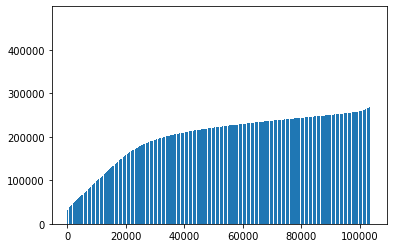

In [81]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(speech_lengths))
y = np.array(speech_lengths)

plt.bar(x, y)
plt.show()

In [82]:
16*16000

256000

In [47]:
from transformers import Wav2Vec2Model

In [48]:
wav2vec2 = Wav2Vec2Model.from_pretrained('facebook/wav2vec2-base')

c:\Users\marco\Google Drive\Projects\.venv\speech-segment-retrieval\lib\site-packages\transformers\configuration_utils.py:363: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2Model: ['project_q.bias', 'project_q.weight', 'quantizer.weight_proj.weight', 'project_hid.weight', 'project_hid.bias', 'quantizer.weight_proj.bias', 'quantizer.codevectors']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model 

In [84]:
extractor = wav2vec2.feature_extractor

In [85]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
extractor.to(device)

In [83]:
16*16000

256000

In [91]:
input = torch.randn(16, 256000, device=device) # 16*256000 worked

In [ ]:
with torch.no_grad():
    features = extractor(input)

In [64]:
print(features.size())

torch.Size([32, 512, 499])


In [2]:
libri = load_dataset('librispeech_asr', 'clean', split='train.360')

Reusing dataset librispeech_asr (C:\Users\marco\.cache\huggingface\datasets\librispeech_asr\clean\2.1.0\14c8bffddb861b4b3a4fcdff648a56980dbb808f3fc56f5a3d56b18ee88458eb)


In [7]:
libri[0]

{'file': 'C:\\Users\\marco\\.cache\\huggingface\\datasets\\downloads\\extracted\\d293e31bd75c2251135d0c00f90128737e778f9a133c800b53221a0e82dfde29\\1487-133273-0000.flac',
 'audio': {'path': 'C:\\Users\\marco\\.cache\\huggingface\\datasets\\downloads\\extracted\\d293e31bd75c2251135d0c00f90128737e778f9a133c800b53221a0e82dfde29\\1487-133273-0000.flac',
  'array': array([ 9.15527344e-05,  4.57763672e-04,  5.18798828e-04, ...,
         -4.57763672e-04, -5.49316406e-04, -4.88281250e-04]),
  'sampling_rate': 16000},
 'text': 'THE SECOND IN IMPORTANCE IS AS FOLLOWS SOVEREIGNTY MAY BE DEFINED TO BE THE RIGHT OF MAKING LAWS IN FRANCE THE KING REALLY EXERCISES A PORTION OF THE SOVEREIGN POWER SINCE THE LAWS HAVE NO WEIGHT',
 'speaker_id': 1487,
 'chapter_id': 133273,
 'id': '1487-133273-0000'}

In [8]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [12]:
sentences = ['something', 'something else', 'something else again']

In [13]:
input = tokenizer(sentences, padding='longest', max_length=64, truncation=True, pad_to_max_length=False)

In [14]:
input

{'input_ids': [[101, 2242, 102, 0, 0], [101, 2242, 2842, 102, 0], [101, 2242, 2842, 2153, 102]], 'token_type_ids': [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 0, 0], [1, 1, 1, 1, 0], [1, 1, 1, 1, 1]]}

In [15]:
extractor = Wav2Vec2FeatureExtractor.from_pretrained('facebook/wav2vec2-base')

In [22]:
input_values = [{'input_values': [0.001861572265625, 0.000518798828125, 0.000244140625, 0.0008544921875, 0.001251220703125, 0.0001220703125, -0.0009765625, -0.001556396484375, -0.001800537109375, -0.001953125, -0.001373291015625, 0.0, -0.000640869140625, -0.001434326171875]}, {'input_values': [0.001861572265625, 0.000518798828125, 0.000244140625, 0.0008544921875, 0.001251220703125, 0.0001220703125, -0.0009765625, -0.001556396484375, -0.001800537109375, -0.001953125, -0.001373291015625, 0.0, -0.000640869140625, -0.001434326171875]}, {'input_values': [0.001861572265625, 0.000518798828125, 0.000244140625, 0.0008544921875, 0.001251220703125, 0.0001220703125, -0.0009765625, -0.001434326171875]}]

In [27]:
padded_values = extractor.pad(input_values, padding='longest', max_length=32, truncation=True, return_tensors='pt', return_attention_mask=True)

In [28]:
padded_values

{'input_values': tensor([[ 0.0019,  0.0005,  0.0002,  0.0009,  0.0013,  0.0001, -0.0010, -0.0016,
         -0.0018, -0.0020, -0.0014,  0.0000, -0.0006, -0.0014],
        [ 0.0019,  0.0005,  0.0002,  0.0009,  0.0013,  0.0001, -0.0010, -0.0016,
         -0.0018, -0.0020, -0.0014,  0.0000, -0.0006, -0.0014],
        [ 0.0019,  0.0005,  0.0002,  0.0009,  0.0013,  0.0001, -0.0010, -0.0014,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)}